In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("StudentPerformanceFactors.csv")
df.columns


Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
       'Previous_Scores', 'Motivation_Level', 'Internet_Access',
       'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type',
       'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities',
       'Parental_Education_Level', 'Distance_from_Home', 'Gender',
       'Exam_Score'],
      dtype='object')

In [73]:
#data cleaning
normalization_dict = {
    'Low': 0.33,
    'Medium': 0.66,
    'High': 0.99,
    'No': 0,
    'Yes': 1,
    'Public': 1,
    'Private': 0,
    'Positive': 1,
    'Neutral': 0.5,
    'Negative': 0,
    'High School': 0.33,
    'College': 0.66,
    'Postgraduate': 0.99,
    'Near': 0,
    'Moderate': 0.5,
    'Far': 1,
    'Male': 1,
    'Female':0,

}

# Use the mapping for regularization
df_normalized = df.copy()

for column in df_normalized.columns:
    if df_normalized[column].dtype == 'object': 
        df_normalized[column] = df_normalized[column].map(normalization_dict)


#check missing
null_values = df_normalized.isna().sum()
print(null_values)



Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


##### Teacher_Quality,Parental_Education_Level,Distance_from_Home have some missing value, but not too much ,del it

In [74]:
df_normalized.dropna(inplace=True)

In [79]:
np.any(df_normalized.duplicated())#check duplicate

False

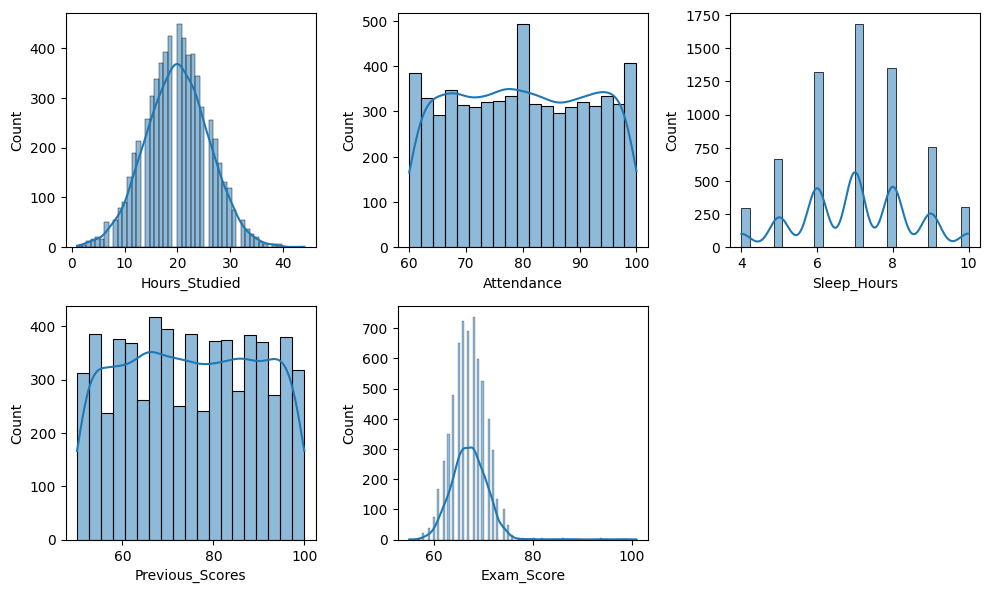

In [96]:
features = [
    'Hours_Studied',
    'Attendance',
    'Sleep_Hours',
    'Previous_Scores',
    'Exam_Score',
]

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

axes = axes.flatten()

for i, feature_x in enumerate(features):
    sns.histplot(df_normalized[feature_x], kde = True,ax=axes[i])

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

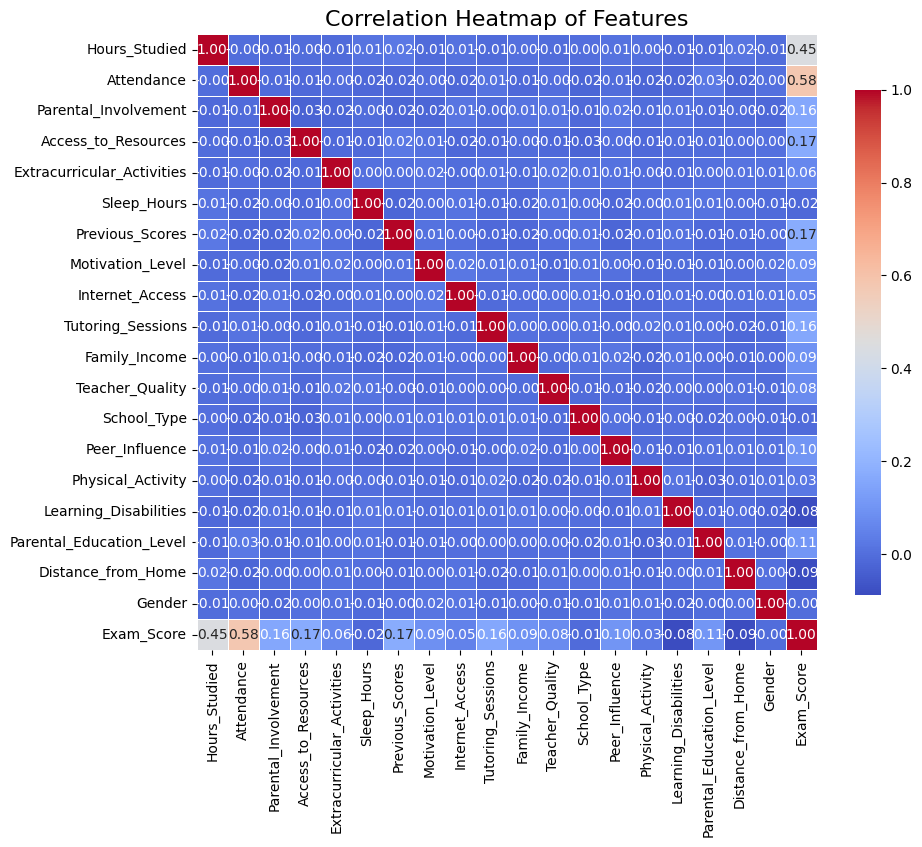

In [75]:
#Pearson correlation coefficient
df_corr = df_normalized.corr()
df_corr
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={"shrink": .82})

plt.title("Correlation Heatmap of Features", fontsize=16)

plt.show()


### It seems that some feature have a slight positive correlation.
#### Exam_score <-> Hours_Studied (0.45)
#### Exam_score <-> Attendance (0.58)
#### Previous_Scores <-> Exam_Score (0.17)

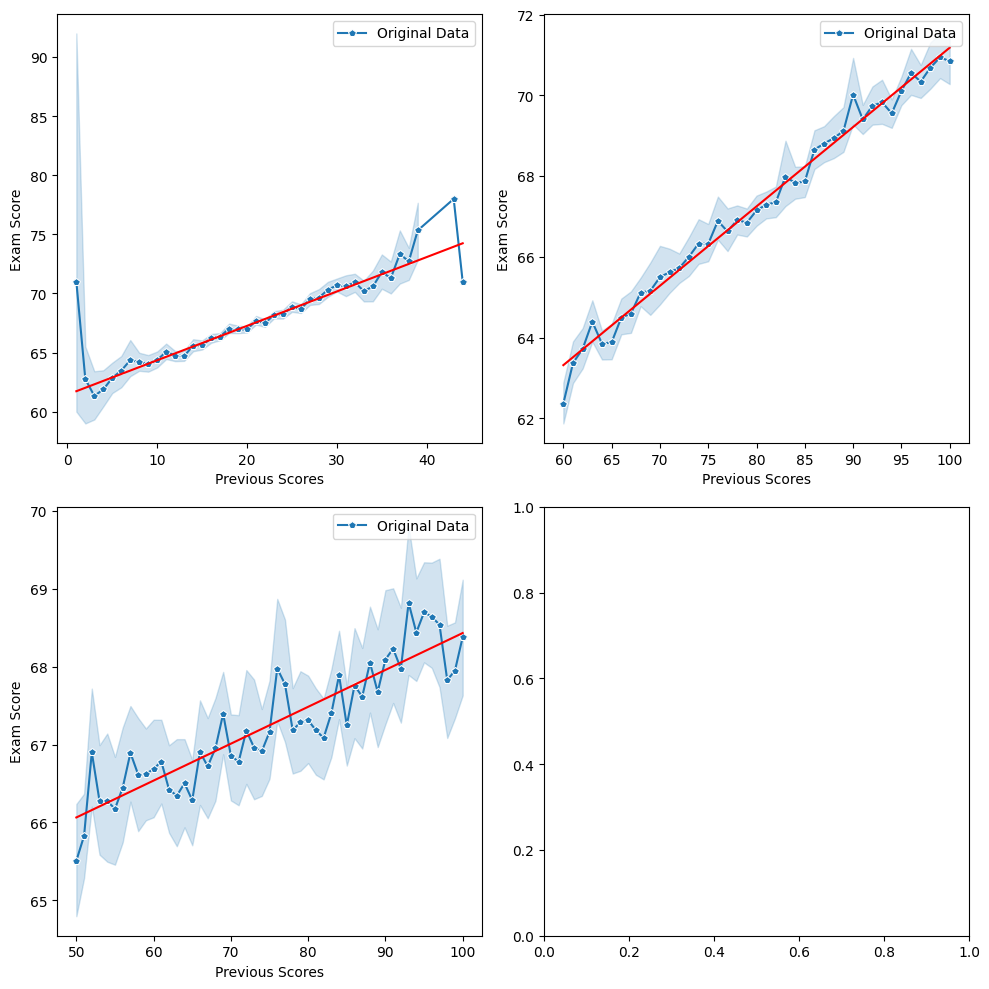

In [131]:
from sklearn.linear_model import LinearRegression
feature_pairs = [
    ('Hours_Studied', 'Exam_Score'),
    ('Attendance', 'Exam_Score'),
    ('Previous_Scores','Exam_Score'),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i, (feature_x, feature_y) in enumerate(feature_pairs):

    X = df_normalized[[feature_x]].values
    y = df_normalized[feature_y].values

    lr = LinearRegression()
    lr.fit(X, y)
    X_test = np.linspace(min(X), max(X), 100).reshape(-1, 1)

    y_pred_linear = lr.predict(X_test)
    sns.lineplot(data=df_normalized, x=feature_x, y=feature_y, marker='p', label="Original Data",ax=axes[i])
    axes[i].plot(X_test, y_pred_linear, color='red', label='Linear Regression Fit')
    axes[i].set_xlabel("Previous Scores")
    axes[i].set_ylabel("Exam Score")

plt.tight_layout()

plt.show()
